In [1]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

In [15]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    # 创建实验
    experiment = pybamm.Experiment(
        ["Rest for 901 s",
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
            "Discharge at 0.96 A for 134 s"
        ]
    )
    # Loading the default parameter set
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    # param["Upper voltage cut-off [V]"] = 5.0
    # param["Initial concentration in electrolyte [mol.m-3]"] = 0.5*param["Separator porosity"]
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        # "Negative electrode diffusivity [m2.s-1]": parameters[17],
        # "Positive electrode diffusivity [m2.s-1]": parameters[18],
        # "Electrolyte diffusivity [m2.s-1]": parameters[19],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-8, 
        rtol=1e-8, 
        dt_max=0.01,  # Decrease the maximum time step
        # max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
    solution = simulation.solve(calc_esoh=False)
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[19]

In [16]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [17]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [18]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

Error for sample 0 with parameters [9.02343750e-05 9.66406250e-05 1.58593750e-05 6.19140625e-01
 4.85351562e-01 1.67578125e-05 1.86328125e-05 1.04921875e+03
 1.10546875e+02 1.38984375e+01 1.59531250e+00 1.59531250e+00
 1.62656250e+00 3.26679688e+04 5.00820312e+04 1.38085938e-01
 2.28320313e-01 4.19921875e-01 1.73828125e-01 3.94062500e-01
 4.23984375e-01]: "Cannot update parameter 'Lower voltage cut-off [V' as it does not have a default value. ('Lower voltage cut-off [V' not found. Use the dimensional version 'Lower voltage cut-off [V]' instead.). If you are sure you want to update this parameter, use param.update({{name: value}}, check_already_exists=False)"
Error for sample 1 with parameters [9.11718750e-05 9.66406250e-05 1.58593750e-05 6.19140625e-01
 4.85351562e-01 1.67578125e-05 1.86328125e-05 1.04921875e+03
 1.10546875e+02 1.38984375e+01 1.59531250e+00 1.59531250e+00
 1.62656250e+00 3.26679688e+04 5.00820312e+04 1.38085938e-01
 2.28320313e-01 4.19921875e-01 1.73828125e-01 3.940625

KeyboardInterrupt: 

In [6]:
param = pybamm.ParameterValues("OKane2022")
print(param)

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x000001FB9EC97420>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008_arrhenius at 0x000001FB9EC96D40>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008_arrhenius at 0x000001FB9EC96CA0>,
 'Electron charge [C]': 1.602176634e-19,
 'Exchange-current density for plating [A.m-2]': <function 

In [26]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

# Define the model
def battery_model(parameters):
    model = pybamm.lithium_ion.SPM()  # 或者 pybamm.lithium_ion.SPM() 进行替换
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.7*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[19]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [27]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                          ST   ST_conf
Negative electrode thickness [m]                    0.013603  0.004207
Positive electrode thickness [m]                    0.107807  0.024534
Separator thickness [m]                             0.000000  0.000000
Negative electrode active material volume fraction  0.006381  0.002158
Positive electrode active material volume fraction  0.547510  0.111195
Negative particle radius [m]                        0.012019  0.003571
Positive particle radius [m]                        0.053022  0.013404
Initial concentration in electrolyte [mol.m-3]      0.000000  0.000000
Negative electrode conductivity [S.m-1]             0.000000  0.000000
Positive electrode conductivity [S.m-1]             0.000000  0.000000
Negative electrode Bruggeman coefficient (elect...  0.000000  0.000000
Positive electrode Bruggeman coefficient (elect...  0.000000  0.000000
Separator Bruggeman coefficient (electrolyte)       0.000000  0.000000
Maximu

In [28]:
categories = [r'$L^{-}$',
              r'$L^{+}$',
              r'$L^{s}$',
              r'$\varepsilon_s^{-}$',
              r'$\varepsilon_s^{+}$',
              r'$R_p^{-}$',
              r'$R_p^{+}$',
              r'$c_{e, 0}$',
              r'$\sigma_s^{-}$',
              r'$\sigma_s^{+}$',
              r'$b^{-}$',
              r'$b^{+}$',
              r'$b^{s}$',
              r'$c_{s, \text { max }}^{-}$',
              r'$c_{s, \text { max }}^{+}$',
              r'$L_{E}$',
              r'$W_{E}$',
              r'$C_{dl}^{-}$',
              r'$C_{dl}^{+}$',
              r'$\varepsilon_e^{-}$',
              r'$\varepsilon_e^{+}$'
              ]

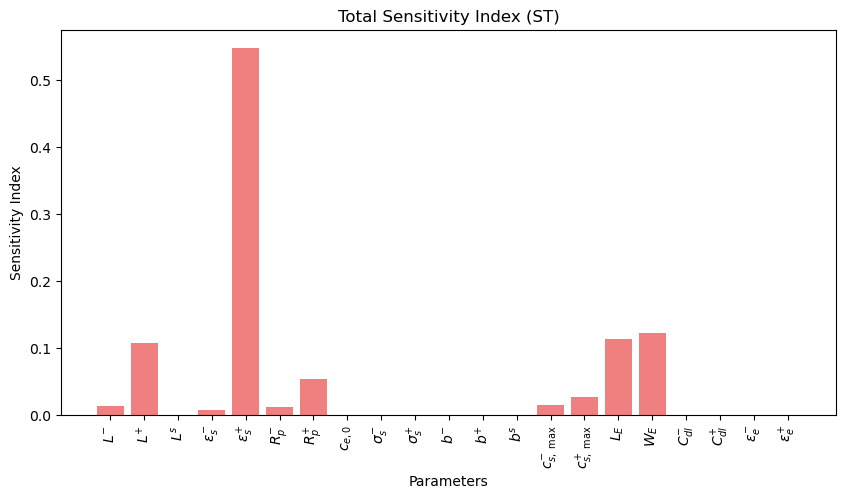

In [29]:
params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [31]:
def battery_model(parameters):
    model = pybamm.lithium_ion.SPM()  # 或者 pybamm.lithium_ion.SPM() 进行替换
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[19]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [32]:
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                          ST   ST_conf
Negative electrode thickness [m]                    0.000433  0.000137
Positive electrode thickness [m]                    0.124917  0.028529
Separator thickness [m]                             0.000000  0.000000
Negative electrode active material volume fraction  0.000316  0.000097
Positive electrode active material volume fraction  0.634401  0.136428
Negative particle radius [m]                        0.000448  0.000132
Positive particle radius [m]                        0.061437  0.015370
Initial concentration in electrolyte [mol.m-3]      0.000000  0.000000
Negative electrode conductivity [S.m-1]             0.000000  0.000000
Positive electrode conductivity [S.m-1]             0.000000  0.000000
Negative electrode Bruggeman coefficient (elect...  0.000000  0.000000
Positive electrode Bruggeman coefficient (elect...  0.000000  0.000000
Separator Bruggeman coefficient (electrolyte)       0.000000  0.000000
Maximu

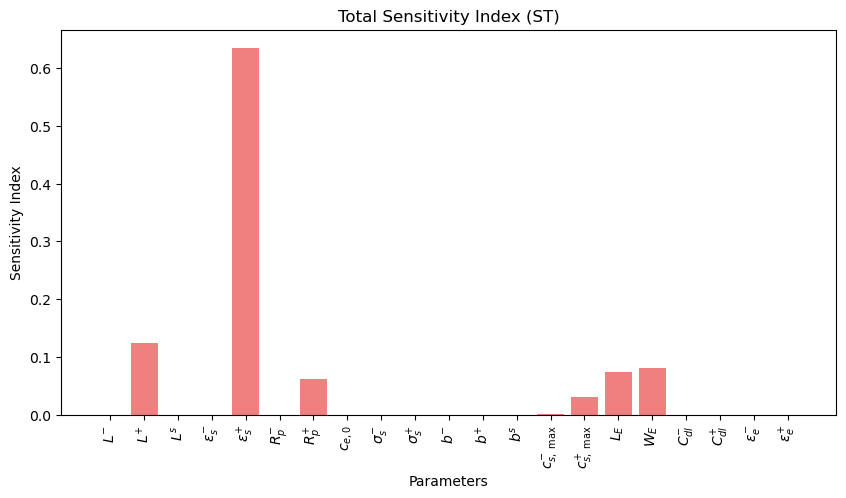

In [33]:
params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [34]:
def battery_model(parameters):
    model = pybamm.lithium_ion.DFN()  
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[19]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [35]:
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    6.784950e-05  2.415790e-05
Positive electrode thickness [m]                    1.152650e-01  2.926470e-02
Separator thickness [m]                             8.672825e-05  2.795464e-05
Negative electrode active material volume fraction  3.140607e-05  9.082336e-06
Positive electrode active material volume fraction  6.213140e-01  1.326686e-01
Negative particle radius [m]                        4.055309e-05  1.205527e-05
Positive particle radius [m]                        6.010032e-02  1.836960e-02
Initial concentration in electrolyte [mol.m-3]      7.234590e-06  2.131449e-06
Negative electrode conductivity [S.m-1]             1.170277e-11  3.935665e-12
Positive electrode conductivity [S.m-1]             6.686339e-10  1.829021e-10
Negative electrode Bruggeman coefficient (elect...  5.263423e-12  2.132066e-12
Positive electrode Bruggeman coefficient (elect...  

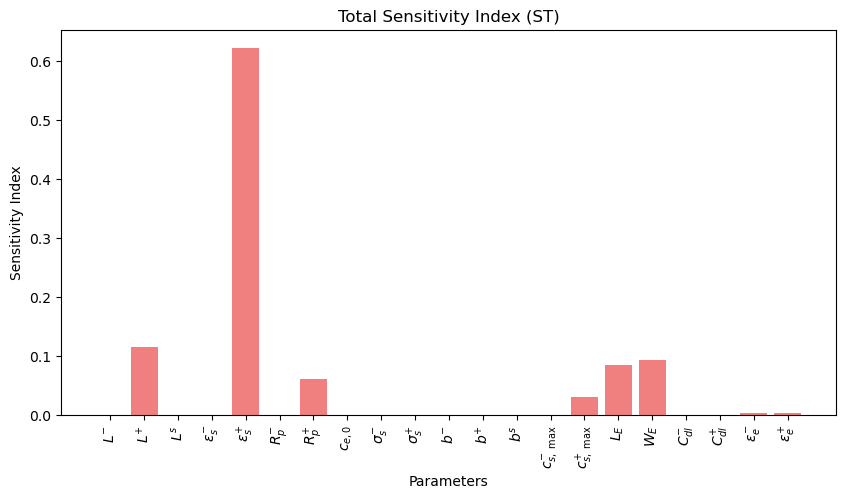

In [36]:
params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [37]:
def battery_model(parameters):
    model = pybamm.lithium_ion.DFN()  
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[20]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [38]:
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    4.116637e-04  1.426654e-04
Positive electrode thickness [m]                    9.977846e-02  2.479694e-02
Separator thickness [m]                             6.153133e-05  1.791789e-05
Negative electrode active material volume fraction  5.991200e-05  1.751625e-05
Positive electrode active material volume fraction  5.974770e-01  1.170797e-01
Negative particle radius [m]                        1.073876e-04  3.072722e-05
Positive particle radius [m]                        1.253474e-01  2.849447e-02
Initial concentration in electrolyte [mol.m-3]      1.061439e-04  2.952893e-05
Negative electrode conductivity [S.m-1]             1.255196e-11  4.036822e-12
Positive electrode conductivity [S.m-1]             3.560686e-11  8.522058e-12
Negative electrode Bruggeman coefficient (elect...  8.247042e-12  3.308126e-12
Positive electrode Bruggeman coefficient (elect...  

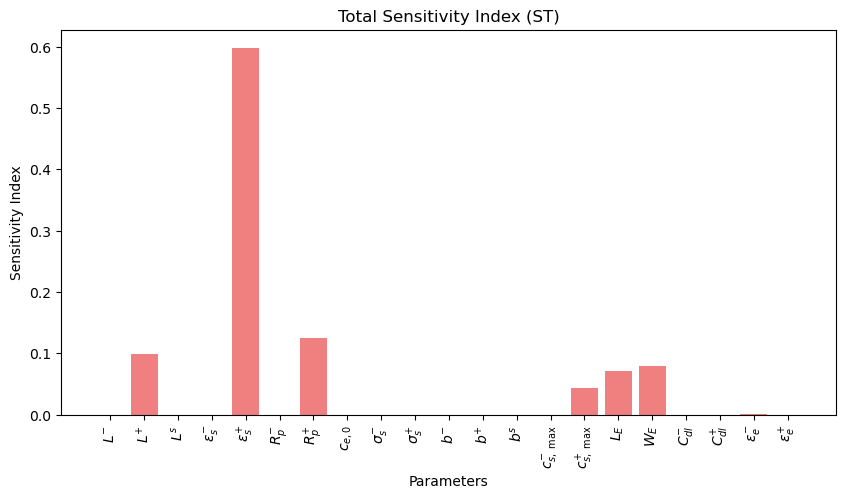

In [39]:
params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

                                                              ST       ST_conf
Negative electrode thickness [m]                    4.116655e-04  1.604056e-04
Positive electrode thickness [m]                    9.977843e-02  2.170607e-02
Separator thickness [m]                             6.153320e-05  1.903656e-05
Negative electrode active material volume fraction  5.990917e-05  1.890836e-05
Positive electrode active material volume fraction  5.974770e-01  1.227040e-01
Negative particle radius [m]                        1.073913e-04  3.282671e-05
Positive particle radius [m]                        1.253474e-01  2.817526e-02
Initial concentration in electrolyte [mol.m-3]      1.061441e-04  3.131312e-05
Negative electrode conductivity [S.m-1]             1.188443e-11  3.923475e-12
Positive electrode conductivity [S.m-1]             3.517845e-11  9.996120e-12
Negative electrode Bruggeman coefficient (elect...  8.629669e-12  3.247966e-12
Positive electrode Bruggeman coefficient (elect...  

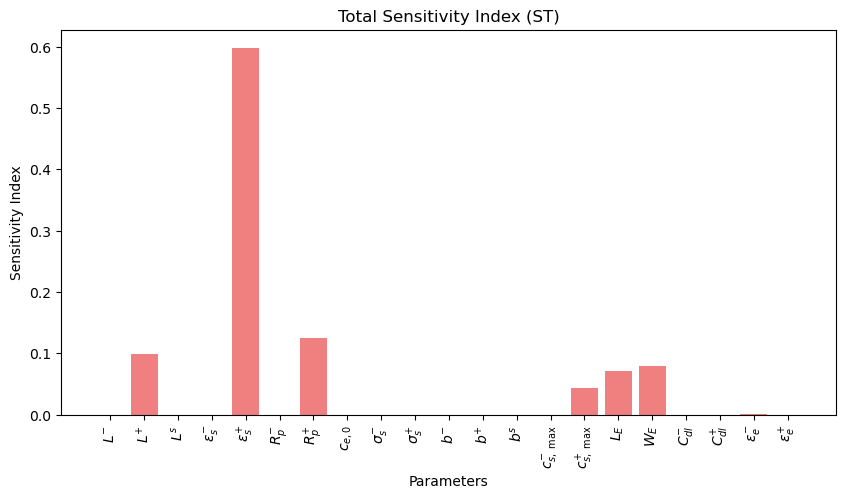

In [40]:
def battery_model(parameters):
    model = pybamm.lithium_ion.DFN()  
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[20]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

Si = sobol.analyze(problem, Y_valid, print_to_console=True)

params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

                                                              ST       ST_conf
Negative electrode thickness [m]                    2.668675e-05  8.551108e-06
Positive electrode thickness [m]                    9.891182e-02  2.328592e-02
Separator thickness [m]                             1.300044e-05  3.921561e-06
Negative electrode active material volume fraction  2.568708e-05  9.452549e-06
Positive electrode active material volume fraction  5.791104e-01  1.496426e-01
Negative particle radius [m]                        6.231595e-05  1.747520e-05
Positive particle radius [m]                        1.440536e-01  3.794387e-02
Initial concentration in electrolyte [mol.m-3]      3.811344e-05  1.056965e-05
Negative electrode conductivity [S.m-1]             2.976886e-12  1.211089e-12
Positive electrode conductivity [S.m-1]             1.114657e-11  2.640225e-12
Negative electrode Bruggeman coefficient (elect...  3.014358e-12  1.792447e-12
Positive electrode Bruggeman coefficient (elect...  

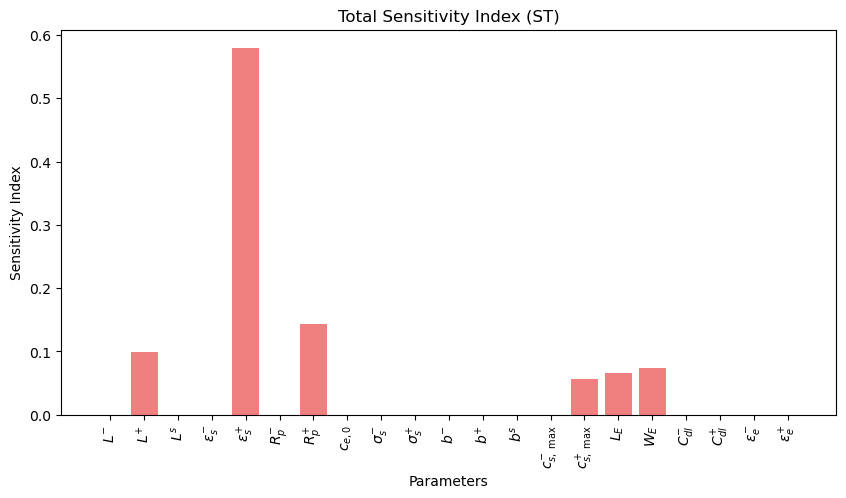

In [41]:
def battery_model(parameters):
    model = pybamm.lithium_ion.DFN()  
    
    experiment = pybamm.Experiment([
        "Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ])
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        return voltage[21]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

Si = sobol.analyze(problem, Y_valid, print_to_console=True)

params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()